In [58]:
import numpy as np
import torch
from datetime import datetime
import glob
import os
import math

os.chdir('/home/jyang4/repos/DK-BO/botorch/')
#import objectives
#import utils
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# %matplotlib notebook

font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [59]:
# subdir = '12-20/test_da3_ll'
# subdir = '01-21/test_sf_ret1fx'
# subdir = '01-21/test_sf_ret10bwint1'
#subdir = 'paper_2022/botorch/nano_TS_test'
# print(subdir)
tensors = sorted(glob.glob('/home/jyang4/repos/DK-BO/results/GB1_batch_UCB/*.pt'))

In [50]:
for t in tensors:
    if 'test' in os.path.basename(t) and 'regret' in t:
        num = t.split('_')[-1].split('reg')[0]
        if num != '15':
            continue
        if 'DO' in t: # and 'MCD' in t:
            print('good', t)
#             print(torch.load(t))
#         elif 'MCD-DO' in t:
#             print('switch', t)
# #         print(t)
        if torch.load(t).size(-1) < 48:
            print(torch.load(t).size(-1))
#         n = t.replace('MCD-DO', 'DO')
#         print(n)
#         os.system('mv ' + t + ' ' + n)

In [51]:
len(tensors)

30

In [53]:
data = torch.load(t)
data.shape

torch.Size([1162])

In [54]:
load = ''
load = 'regret' # put '' for all
lim = 48
# print(tensors)
# [print(t.split('/')[-1].split('regret')[0]) for t in tensors if 'regret' in t]
# name : (dtype:tensor)
tests = {}
bad = []
# assuming not getting models out
for i in tqdm(range(len(tensors))):
    tensor = tensors[i]
#     if 'EGrbf' in tensor or 'TSrbf' in tensor or 'EGlin' in tensor:
#         continue
    if load not in tensor.lower():
        continue
    if '.pt' in tensor and 'state_dict' not in tensor:
#         num = int(tensor.split("_")[-1].split('regret.')[0])
#         if num > 10:
#             continue
#         if 'sweep' not in tensor:
#             continue
        first = False
        nm = os.path.basename(tensor).split('_')[0]
        t = torch.load(tensor).cpu().detach()
        t = torch.reshape(t, (1, -1))
#         print(tensor)
#         print(t.size(-1))
#         lim = 00
#         lim = 1000
        rand = 10
#         if 'regret.pt' in tensor and int(tensor.split('_')[-1].split('regret')[0]) > 15:
#             print(tensor)
#             continue
        if ('y.pt' in tensor and t.size(-1) < lim + rand) or ('y.pt' not in tensor and t.size(-1) < lim):
            if 'regret.pt' in tensor:
                bad.append(os.path.basename(tensor).split("regret")[0])
#                 print(tensor.split('regret.pt')[0].split('/')[-1])
            continue
        if nm in tests.keys():
            d = tests[nm]
        else:
            d = {}
            tests[nm] = d
        dtype = os.path.basename(tensor).split('_')[-1].split('.')[0]
        dtype = ''.join([i for i in dtype if not i.isdigit()])
        if dtype in d.keys():
            arr = d[dtype]
        else:
            arr = t
            d[dtype] = arr
            first = True
        if first:
            pass
        elif t.size(-1) < arr.size(-1):
#             arr = torch.cat((arr[t.size(-1)], t), 0)
            arr = torch.cat((arr[:,:t.size(-1)], t), 0)
        else:
            arr = torch.cat((arr, t[:,:arr.size(-1)]), 0)
#             arr = torch.cat((arr, t[arr.size(-1)]), 0)
#         arr = torch.cat((arr, t), 0)
#         print(arr)
#         print(t)
        d[dtype] = arr
        tests[nm] = d
print(sorted(bad))
# print(tests)
# aggreggate data
# dtype: (name:tensor)
batch = {}
budget, total= math.inf, math.inf
for key in tests.keys():
    print(key)
    for dtype in tests[key].keys():
#         print(dtype)
        t = tests[key][dtype]
#         print(t[:, -1])
        if 'regret' == dtype and t.size(-1) < budget and t.size(-1) != 0:
#             print(dtype)
            budget = t.size(-1)
#             num_runs = t.size(0)
        elif 'y' in dtype and t.size(-1) < total and t.size(-1) != 0:
            total = t.size(-1)
        sd, mean = torch.std_mean(t, 0)
#         print(sd)
#         print((t.size(0)**.5))
        sem = sd / (t.size(0)**.5)
        if dtype in batch.keys():
            d = batch[dtype]
        else:
            d = {}
            batch[dtype] = d
        d[key] = (mean, sem)
        batch[dtype] = d
    print("Runs: {}".format(t[:, -1].size(-1)))
print(batch.keys())
# runs = int(len(tensors)/(7 * (len(tests) - 1)))
# print('Avg runs: {}'.format(runs))
print('Budget: {}'.format(budget))
# print('Total queries (incl. init): {}'.format(total))

100%|██████████| 30/30 [00:00<00:00, 34865.37it/s]

[]
DKLsweep-5DO-0-RBF-UCB
Runs: 3
GP-RBF-UCB
Runs: 3
Random
Runs: 3
dict_keys(['regret'])
Budget: 49


In [55]:
# batch['y']['DKLfsweep-50MCDnoDO-0.5-Lin-TS'][0] - batch['y']['DKLfsweep-50MCDnoDO-0.3-Lin-TS'][0]

In [56]:
def norm(x, max = 8.762):
    return (max - x)/max

def plot_regret(tests, budget, fname=None, randregret=None):
    '''Pass in list of bo objects and labels.'''
    handles = []
#     s = [None, None, None, None]
    s= []
    dc, gc = 0, 0
    dcol = ['tab:red', 'tab:orange', 'tab:pink', 'tab:green', 'tab:cyan', 'tab:olive']
    gcol = ['tab:green', 'tab:cyan', 'tab:olive', 'tab:red', 'tab:orange', 'tab:pink']
    tcols = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange']
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(6, 4))
    names = []
    queries = np.arange(budget)
#     if randregret != None:
#         names.append('Random')
#         mean, sem = randregret
#         p = plt.plot(queries, mean, color='black')
#         plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    davgm, davgsd = 0, 0
    gavgm, gavgsd = 0, 0
    dcnt, gcnt = 0, 0
    for name in sorted(tests.keys()):
#         if 'sweep' in name and 'fsweep' not in name and 'DO' not in name:
#             continue
#         if 'sweep' not in name and '200' not in name and 'DKL-20Lin-TS' not in name and 'Random' not in name and 'DKL-20MCD-0.3-Lin-TS' != name and '20DO-0.3' not in name:
#             continue
#         if 'sweep' in name and ('0.1' not in name):
#             continue
#         if 'test' in name:
#             continue
#         if 'UCB' in name:
#             continue
        if 'WD' in name or ('noDO' in name and 'fsweep' not in name):
            continue
#         if 'GP' in name:
#             continue
#         if 'MCD' in name or 'DO' in name:
#             continue
#         if '2' in name: # or 'GP' in name or 'UCB' in name:
#             continue
#         if 'MCD' in name:
#             continue
#         if ('MCD' not in name and 'DO' not in name) or 'UCB' in name:
#             if name != 'DKL-20Lin-TS' and name != 'DKL-50Lin-TS':
#                 continue
#         if 'DKL' in name and ('MCD' in name or 'DO' in name):
#             pass
#         elif 'GP' not in name and 'Random' not in name:
#             continue
#         if 'noDO' in name or 'GP' in name:
#             continue
#         if "noDO" in name or "GP-Lin-UCB" in name or 'RBF' in name:
#             continue
#         if '58' in name:
#             continue
#         if '176' not in name and 'GP' not in name:
#             continue
#         if name != 'DKL-58MCD-0.3-Lin-TS' and name != 'GP-Lin-UCB':
#             continue
#         if name != 'DKL-MCD-0.2-RBF-UCB' and name != 'GP-Lin-UCB':# and 'Random' not in name:
#         if 'TS' not in name:# or 'EG' in name: #and 'Random' not in name:
#             continue
        mean, sem = tests[name]
        if mean.size(0) < budget:
            print(mean.size(0))
            names.pop()
            continue
        if mean.size(0) > budget:
#             print(name)
            print(mean.size(-1))
            mean = mean[:budget]
            sem = sem[:budget]
        if 'DKL' in name:
            davgm += mean
            davgsd += sem
            dcnt += 1
        if 'GP' in name:
            gavgm += mean
            gavgsd += sem
            gcnt += 1
#         if 'RBF' in name:
#             continue
#         if 'DKL' in name and 'DO' not in name:
#             continue
#         elif 'DKL' in name and '0.3' not in name:
#             continue
#             else:
#                 continue
#         if ('MCD' in name and 'TS' in name) or 'GP' in name or 'Random' in name or ('DO' in name and 'UCB' in name):
#             pass
#         else:
#             continue
#         naming
#         if 'DKL' in name:
#             if '2' in name:
#                 names.append('DK-BO, 2D-' + name.split('2')[-1])
#             else:
#                 names.append('DK-BO, 50D-' + name.split('50')[-1])
#             names.append('DK-BO, MCD-Lin-TS')
#         elif 'GP' in name:
#             names.append('GP-BO, Lin-TS')
#         else:
#         names.append(name)
#         names.append(name.replace('50', '').replace('20', '').replace('-0.3', '').replace('2', ''))
        if 'Random' in name:
            rand = mean, mean-sem, mean+sem
#             p = plt.plot(queries, mean, color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.1)
        else:
#             if 'noDO' in name:
#                 names[-1] = names[-1].replace('-noDO', '')
#             elif 'MCD' in name and 'DO' not in name:
#                 names[-1] = 'DKL-MCD-DO-Lin-TS'
            s.append((name, mean, sem))
#             if 'test' in name and 'DO' in name:
#                 s[0] = (name, mean, sem)
#             elif 'test' in name and 'MCD' in name:
#                 s[1] = (name, mean, sem)
#             elif 'MCD' in name:
#                 s[2] = (name, mean, sem)
#             elif 'DO' in name:
#                 s[3] = (name, mean, sem)
#             if '2' in name and gc < len(gcol):
# #                 names[-1] = '2-' + names[-1]
#                 col = gcol[gc]
#                 gc += 1
#             elif '' in name and dc < len(dcol):
# #                 names[-1] = '50-' + names[-1]
#                 col = dcol[dc]
#                 dc += 1
# #             p = plt.plot(queries, mean, color=col)
#             if 'DKL' in name:
#                 l = 1.5
#                 p = plt.plot(queries, mean, linewidth=l, color=dcol[dc])
# #                 dc += 1
#                 names.append(name.replace('50', '').replace('DKL-', 'DK-BO, ').replace('DO-0.3-', '').replace('2', ''))
#             else:
#                 l = 1.5
#                 p = plt.plot(queries, mean, linewidth=l, color=gcol[gc])
# #                 gc += 1
#                 names.append(name.replace('GP-', 'GP-BO, '))
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
#         handles.append(p)
        print(name)
        print(mean[-1])
    

    for i, (name, mean, sem) in enumerate(s):
#         names.append('DK-BO, ' + name.split('DKL-')[-1].split('Lin')[0] + 'D-Lin-TS')
        names.append(name)
#         p = plt.plot(queries, mean, linewidth=1.5, color=tcols[i])
        p = plt.plot(queries, norm(mean), linewidth=1.5, label=name)
        plt.fill_between(queries, norm(mean - sem), norm(mean + sem), color=p[-1].get_color(), alpha=.15)
#     do average
#     davgm = davgm / dcnt
#     davgsd = davgsd / dcnt
#     p = plt.plot(queries, davgm, color='tab:orange')
#     plt.fill_between(queries, davgm - davgsd, davgm + davgsd, color=p[-1].get_color(), alpha=.15)
#     names.append('DK-BO, Mean')
#     handles.append(p)
#     print("Avg DKL, {}".format(davgm[-1]))
#     gavgm = gavgm / gcnt
#     gavgsd = gavgsd / gcnt
#     p = plt.plot(queries, gavgm, color='tab:blue')
#     plt.fill_between(queries, gavgm - gavgsd, gavgm + gavgsd, color=p[-1].get_color(), alpha=.15)
#     handles.append(p)
#     names.append('GP-BO, Mean')
#     print("Avg GP, {}".format(gavgm[-1]))

    p = plt.plot(queries, norm(rand[0]), color='black')
    plt.fill_between(queries, norm(rand[1]), norm(rand[2]), color='black', alpha=.1)
    names.append("Random")
#     plt.rcParams.update({'font.size': 22})
    plt.rc('xtick') 
    plt.rc('ytick')
    plt.ylabel('Max Fitness Achieved')
    plt.xlabel('Queries')

    plt.axhline(y = 0.72, color = 'g', linestyle = '-')
    plt.ylim([0, 1])
    plt.plot()
#     plt.legend(names, bbox_to_anchor=(1,1), loc="upper left", fontsize=26)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#     plt.title('Regret: GB1', pad=10, fontsize=28)
#     plt.title('Regret', pad=10, fontsize=28)
#     plt.yscale('log')

#     print(handles, names)
#     order = [0, 3, 1, 4, 2]
#     plt.legend([handles[idx] for idx in order],[names[idx] for idx in order])

    if fname != None:
        plt.savefig(fname, dpi=600, bbox_inches='tight')
    plt.show()
    return handles

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

DKLsweep-5DO-0-RBF-UCB
tensor(4.7822)
GP-RBF-UCB
tensor(5.3049)
1153
Random
tensor(5.1339)


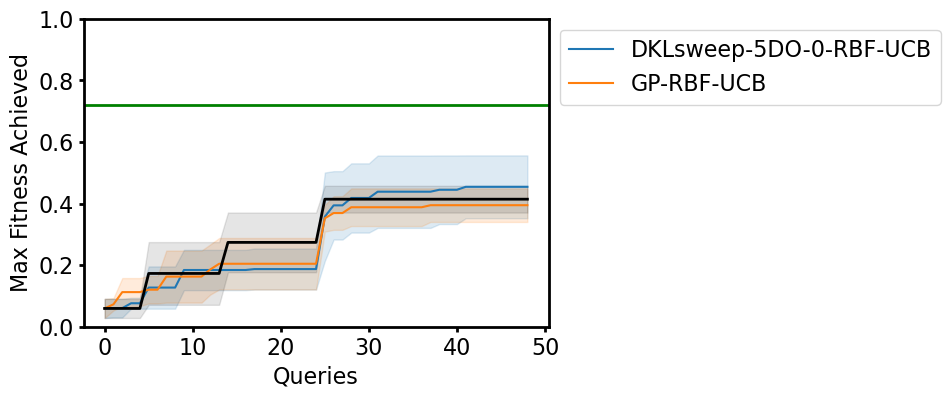

In [57]:
sv = None
# sv = 'figs/arc_g'

handles = plot_regret(batch['regret'], budget, fname=sv, randregret=None)


In [8]:
plot_regret(batch['errors'], budget-1, randregret=None)

KeyError: 'errors'

In [9]:
plot_regret(batch['ll'], budget-1, randregret=None)

KeyError: 'll'

In [10]:
def plot_mae(train, budget, test=None):
    '''Pass in list of bo objects and labels.'''
    # train, test is name:(mean, sem)
    mx, mn = 0, 1
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    # should be same names
    for name in sorted(train.keys()):
#         if '2500' not in name and 'GP' not in name:
#             continue
        mean, sem = train[name]
        print(name)
#         print(mean)
        names.append(name + ' (train)')
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                mean = mean[:budget]
                sem = sem[:budget]
        p = plt.plot(queries, mean)
        plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
        if test != None:
            mean, sem = test[name]
#             print(mean)
            if mean.size(0) > budget:
                mean = mean[:budget]
                sem = sem[:budget]
            p = plt.plot(queries, mean, color=p[-1].get_color(), linestyle='dotted')
            names.append(name + ' (test)')
            plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
        print(mean[-1])
        h, l = max(mean), min(mean)
        if h > mx:
            mx = h
        if l < mn:
            mn = l
    print("test: min {}, max {}, range {}".format(mn, mx, mx-mn))
    plt.ylabel('MAE', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.title('MAE:', pad=10, fontsize=20)
    plt.legend(names)
    plt.show()
    
%matplotlib inline
# skip objective
# plot_mae(batch['ratrainmae'], budget, test=batch['ratestmae'])

In [11]:
def batch_distances(x, batch_size):
    ind = 0
    distances = []
    for i in range(0, x.size(0), batch_size):
        total = 0
        for j in range(i, i + batch_size):
            curr = x[j]
            for k in range(j, i + batch_size):
                total += torch.sum(torch.abs((curr - x[k])**2)).item()**.5
        distances.append(total)
    return distances

def calc_distance(x):
    total = 0
    for i in range(x.size(0)):
        curr = x[i]
        for j in range(i, x.size(0)):
            total += torch.sum(torch.abs((curr - x[j])**2)).item()**.5
    return total/x.size(0)

def calc_distances(filenames, batch=5):
    fig = plt.figure(figsize=(15, 12))
    for fname in filenames:
        print(fname.split('/')[-1])
        x = torch.load(fname + 'x.pt')
        y = torch.load(fname + 'y.pt')
        axis = torch.Tensor(range(int(x.size(0)/batch)))
        print(calc_distance(x))
        print(calc_distance(y))
        plt.plot(axis, batch_distances(x, batch))
        plt.plot(axis, batch_distances(y, batch))
    plt.legend([f.split('/')[-1] for f in filenames])
    plt.yscale('log')
    plt.show()

In [12]:
def plot_y(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
        plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
#         if 'TS' not in name:
#             continue
        print(name)
#         if '2500' not in name and 'GP' not in name:
#             continue
        names.append(name)
        mean, sem = tests[name]
        print(torch.max(mean))
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                print(mean.size(-1))
                mean = mean[:budget]
                sem = sem[:budget]
        reg = []
        for i in range(budget):
            reg.append(torch.max(mean[:i+1]))
        if 'Random' in name:
            p = plt.plot(queries, mean, color='black')
            plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, mean)
            plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
plot_y(batch['y'], total, randregret=None)

KeyError: 'y'

In [13]:
def plot_yavg(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget + 1)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
#         plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
#         if '2500' not in name and 'GP' not in name:
#             continue
        names.append(name)
        obj_max = objectives.Proteins_td.get_max()
        mean, sem = tests[name]
        mean = obj_max - mean
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                print(mean.size(-1))
                mean = mean[mean.size(0) - budget - 1:]
                sem = sem[mean.size(0) - budget:]
        running = []
        for y in range(mean.size(-1)):
            running.append(torch.reshape(torch.mean(mean[:y]), (1,1)))
        running = torch.cat(running, 0)
        if 'Random' in name:
            p = plt.plot(queries, running, color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, running)
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Running Average', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
plot_yavg(batch['y'], total-1, randregret=None)

KeyError: 'y'

In [ ]:
# print(tests)
def get_individ(name):
    individ = []
    for key in tests.keys():
        ind = 0
        if name == 'acq' and 'Random' in key:
            continue
        for run in tests[key][name]:
            try:
                arr = individ[ind]
            except:
                arr = {}
                individ.append(arr)
            arr[key] = run
            individ[ind] = arr
            ind += 1
    return individ

In [ ]:
ind_y = get_individ('y')
ind_acq = get_individ('acq')

In [ ]:
def plot_ind(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    for name in sorted(tests.keys()):
        names.append(name)
        y = tests[name]
#          or 'DKL' in name
        if y.size(0) < budget:
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        if 'Random' in name:
            p = plt.plot(queries, y.detach().numpy(), color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, y.detach().numpy())
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Individual Run', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()

In [ ]:
def plot_two(tests1, tests2, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    for name in sorted(tests1.keys()):
        names.append(name + 'y')
        y = tests1[name]
#          or 'DKL' in name
        if 'Random' in name or y.size(0) < budget:
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        p = plt.plot(queries, y.detach().numpy())
    for name in sorted(tests2.keys()):
        names.append(name + 'acq')
        y = tests2[name]
#          or 'DKL' in name
        if 'Random' in name or y.size(0) < budget:
            print(y.size(0))
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        p = plt.plot(queries, y.detach().numpy())
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Individual Run', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()

In [ ]:
# for run1, run2 in zip(ind_y, ind_acq):
#     plot_two(run1, run2, total - 1)

In [ ]:
def plot_cum(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    for name in sorted(tests.keys()):
        names.append(name)
        y = tests[name]
#          or 'DKL' in name
        if y.size(0) < budget:
            names.pop()
            continue
        if y.size(0) > budget:
                print(mean.size(-1))
                y = y[:budget]
#                 sem = sem[:budget]
#         running = []
#         for out in range(y.size(-1)):
#             running.append(torch.reshape(torch.mean(y[:out]), (1,1)))
#         running = torch.cat(running, 0)
        if 'Random' in name:
            p = plt.plot(queries, y.detach().numpy(), color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, y.detach().numpy())
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs: Individual Run', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()

In [ ]:
regs = {}
obj_max = objectives.Proteins_td.get_max()
for run in ind_y:
    for m in run.keys():
        reg = []
        for i in range(run[m].size(-1)):
            s = 0
            for j in range(0, i + 1):
                s += (obj_max - run[m][j])
#             reg.append(s / (i+1))
            reg.append(torch.reshape(s/(i+1), (1, 1)))
        if m not in regs.keys():
            arr = []
        else:
            arr = regs[m]
        arr.append(torch.cat(reg, -1))
        regs[m] = arr
    

# print(regs)                
#     print(run)
#     plot_cum(run, budget)

In [ ]:
fig = plt.figure(figsize=(15, 10))
queries = np.arange(budget + 9)
cum_arr = []
names = sorted(regs.keys())
for key in names:
    t = torch.cat(regs[key], 0)
    sd, mean = torch.std_mean(t, 0)
    p = plt.plot(queries, mean)
#     plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    
#     s = 0
#     for t in regs[key]:
#         s += t
#     cum_arr.append(s / len(regs[key]))
    
print(cum_arr)
plt.legend(names)
# plt.yscale('log')
plt.show()

In [ ]:
# for run in ind_acq:
#     plot_ind(run, budget - 1)

In [ ]:
# subdir = 'trashlc2'
lcnames = glob.glob('data/' + subdir + '/*lc.pt') + glob.glob('data/' + subdir + '/*loss.pt')
# print(lcnames)
for name in sorted(lcnames):
    if '23' in name:
        continue
    fig = plt.figure(figsize=(6, 4))
    print(os.path.basename(name))
    t = torch.load(name)
    queries = list(range(t.size(-1)))
    for curve in range(t.size(0)):
        plt.plot(queries, t[curve])
    plt.legend(list(range(t.size(0))))
    plt.show()
#     print(t)

In [ ]:
# plots regret of average y (not entirely accurate)
def plot_y(tests, budget, randregret=None):
    '''Pass in list of bo objects and labels.'''
    # tests is name:(mean, sem)
    fig = plt.figure(figsize=(15, 10))
    names = []
    queries = np.arange(budget)
    if randregret != None:
        names.append('Random')
        mean, sem = randregret
        p = plt.plot(queries, mean, color='black')
        plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
    for name in sorted(tests.keys()):
        print(name)
#         if '2500' not in name and 'GP' not in name:
#             continue
        names.append(name)
        mean, sem = tests[name]
        print(torch.max(mean))
        if mean.size(0) < budget:
            names.pop()
            continue
        if mean.size(0) > budget:
                print(mean.size(-1))
                mean = mean[:budget]
                sem = sem[:budget]
        reg = []
        for i in range(budget):
            reg.append(torch.max(mean[:i+1]))
        if 'Random' in name:
            p = plt.plot(queries, reg, color='black')
#             plt.fill_between(queries, mean - sem, mean + sem, color='black', alpha=.15)
        else:
            p = plt.plot(queries, reg)
#             plt.fill_between(queries, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    plt.ylabel('y', fontsize=14)
    plt.xlabel('# queries', fontsize=14)
    plt.legend(names)
    plt.title('Outputs', pad=10, fontsize=20)
#     plt.yscale('log')
    plt.show()
    
%matplotlib inline
# skip objective
# plot_y(batch['y'], total, randregret=None)

In [ ]:
# flips y graph to match regret->0
# regrets = []
# ys = {}
# for run in ind_y:
#     for key in run.keys():
#         if key in ys:
#             arr = ys[key]
#             arr.append(run[key])
#             ys[key] = arr
#         else:
#             ys[key] = [run[key]]
# for key in ys.keys():
#     ind_regs = []
#     for t in ys[key]:
#         reg = []
#         for i in range(t.size(-1)):
#             reg.append(torch.reshape(torch.max(t[:i+1]), (1, -1)))
#         ind_regs.append(torch.cat(reg, -1))
# #     avg_reg = 0
# #     count = 0
# #     for reg in ind_regs:
# #         avg_reg += reg
# #         count += 1
# #     avg_reg /= count
#     sd, mean = torch.std_mean(torch.cat(ind_regs, 0), 0)
#     regrets.append((key, sd, mean))
# fig = plt.figure(figsize=(15, 10))
# names = []
# queries = np.arange(budget)
# for key, sd, mean in regrets:
#     if mean.size(0) > budget:
# #         print(mean.size(-1))
#         mean = 11.8260 - mean[:budget]
#         sd = sd[:budget]
#     names.append(key)
#     p = plt.plot(queries, mean.detach().numpy())
#     plt.fill_between(queries, mean - sd, mean + sd, color=p[-1].get_color(), alpha=.15)
# plt.ylabel('regret', fontsize=14)
# plt.xlabel('# queries', fontsize=14)
# plt.legend(names)

In [ ]:
lst = [1,2,3,4,5]
lst2 = lst
lst2.reverse()
print(lst)
print(lst2)